# Linear Regression Model 

predict the magnitude or severity (Total Deaths, Total Affected) based on disaster type, region, subregion, disaster duration, start month.

Attempt to implement and analyze a linear regression model. With the goal of predicting the magnitude or severity of disasters (total deaths or total affected individuals) based on various features like disaster type, region, subregion, disaster duration, and start month.

- Model Implementation:
    - LinearRegression
    - Ensemble methods:
        - VotingRegressor
        - RandomForestRegressor
        - XGBRegressor
    
- Metrics: mean_squared_error and r2_score were used to evaluate the regression models.

### Failure to achieve a reasonable prediction from linear regression models 

Possible reasons for failure: 
- Feature Relevance: Some predictors might lack strong correlation with target variables.
- Model Limitations: Linear models may struggle with non-linear relationships in data.
- Overfitting: Complex models like Random Forest or XGB may have overfitted to training data.

Mitigation: Use models that can handle non-linear relationships. 

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For regression model 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Ensemble models 
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor

# For data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [24]:
# Need to install xgboost for gradient boost regressor
#!pip install xgboost

In [25]:
from xgboost import XGBRegressor

### Data Loading and Visualization

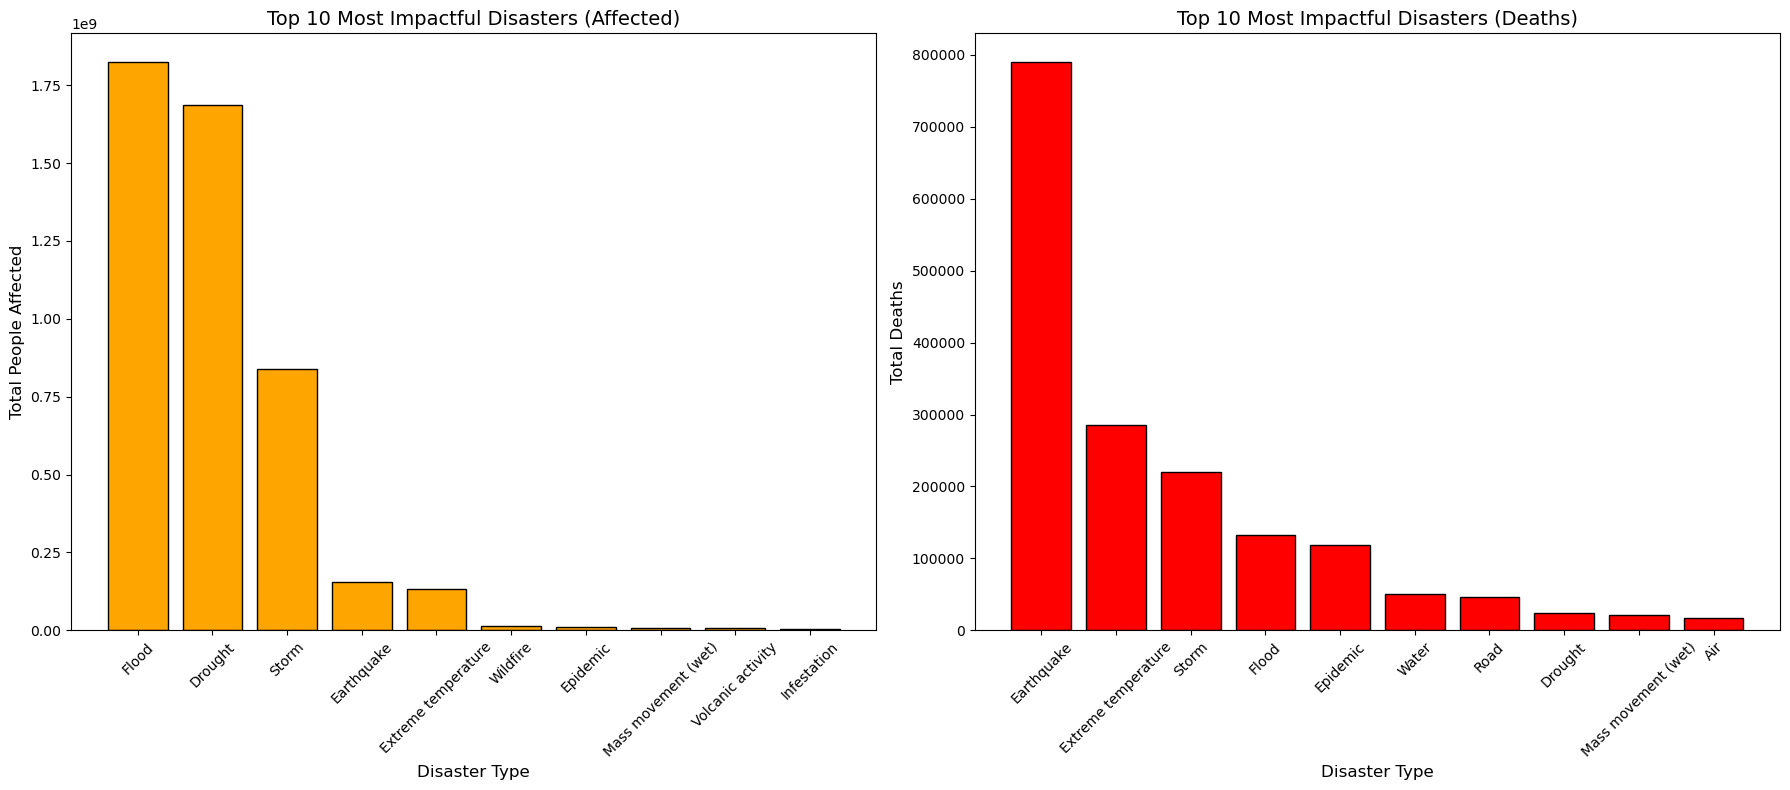

In [26]:
# Load the dataset
data_path = "./emdat_2020-2024_cleaned.csv" 
data = pd.read_csv(data_path)

# Aggregate by Disaster Type for both damages and deaths
impact_affected = data.groupby('Disaster Type')['Total Affected'].sum().sort_values(ascending=False).head(10)
impact_deaths = data.groupby('Disaster Type')['Total Deaths'].sum().sort_values(ascending=False).head(10)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot for Total Affected
axes[0].bar(impact_affected.index, impact_affected.values, color='orange', edgecolor='black')
axes[0].set_title('Top 10 Most Impactful Disasters (Affected)', fontsize=14)
axes[0].set_xlabel('Disaster Type', fontsize=12)
axes[0].set_ylabel('Total People Affected', fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)

# Plot for Total Deaths
axes[1].bar(impact_deaths.index, impact_deaths.values, color='red', edgecolor='black')
axes[1].set_title('Top 10 Most Impactful Disasters (Deaths)', fontsize=14)
axes[1].set_xlabel('Disaster Type', fontsize=12)
axes[1].set_ylabel('Total Deaths', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

# Feature Selection & Engineering

In [41]:
# Pick out the relevant Features for linear regression
relevant_features = [
    'Region', 'Subregion', 'Country',
    'Start Month', 'Disaster Duration', 'Disaster Type', 'Total Deaths'
]

# Separate features and target
X = data[relevant_features]
y = data['Total Affected']

# Split the data into validation, test, and train 

# Training and temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Validation and test from the temporary set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Identify numerical and categorical columns
cat_cols = X.select_dtypes(include=['object']).columns

# Apply One-Hot Encoding to the categorical columns
onehot = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')  # Keep numerical columns as they are

# Fit and transform the training and test datasets
X_train_encoded = onehot.fit_transform(X_train)
X_test_encoded = onehot.transform(X_test)
X_val_encoded = onehot.transform(X_val)


# Display the transformed data shape
X_train_encoded.shape, X_test_encoded.shape, X_val_encoded.shape

Training set size: 11162
Validation set size: 2392
Test set size: 2393


((11162, 274), (2393, 274), (2392, 274))

In [42]:
# Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train_encoded, y_train)

# Validate the Model
y_val_pred = model.predict(X_val_encoded)

# Evaluate performance on the validation set
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation Mean Squared Error: {val_mse}")
print(f"Validation R-squared Score: {val_r2}")

Validation Mean Squared Error: 5895469087380.5205
Validation R-squared Score: 0.043153424193214884


In [43]:
y_test_pred = model.predict(X_test_encoded)

# Evaluate performance on the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test R-squared Score: {test_r2}")

Test Mean Squared Error: 3147260772708.8364
Test R-squared Score: -0.06055975923523249


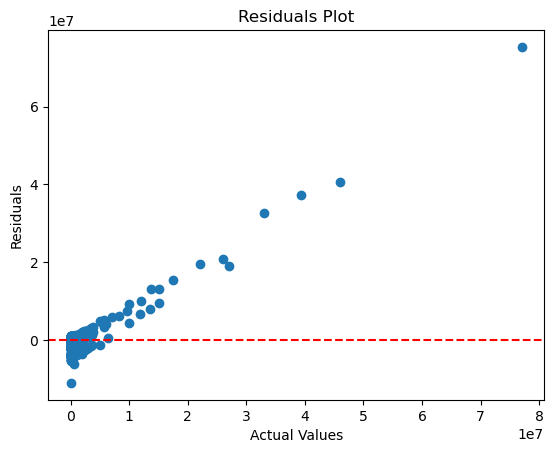

In [44]:
residuals = y_val - y_val_pred
plt.scatter(y_val, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [45]:
# Define individual models
linear_model = LinearRegression()
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Create an ensemble model using VotingRegressor
ensemble_model = VotingRegressor(estimators=[
    ('lr', linear_model),
    ('rf', random_forest_model),
    ('xgb', xgb_model)
])

# Train the ensemble model on the processed training data
ensemble_model.fit(X_train_encoded, y_train)

# Predict on the validation set
y_val_pred = ensemble_model.predict(X_val_encoded)

# Evaluate performance on the validation set
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation Mean Squared Error (Ensemble): {val_mse}")
print(f"Validation R-squared Score (Ensemble): {val_r2}")

# Predict on the test set
y_test_pred = ensemble_model.predict(X_test_encoded)

# Evaluate performance on the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test Mean Squared Error (Ensemble): {test_mse}")
print(f"Test R-squared Score (Ensemble): {test_r2}")

Validation Mean Squared Error (Ensemble): 5594450764671.084
Validation R-squared Score (Ensemble): 0.09200930776593386
Test Mean Squared Error (Ensemble): 2916781047930.7036
Test R-squared Score (Ensemble): 0.017106992607803573


In [46]:
# Define the XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=200,       # Number of boosting rounds
    learning_rate=0.1,      # Step size shrinkage
    max_depth=5,            # Maximum depth of a tree
    random_state=42         # For reproducibility
)

xgb_model.fit(X_train_encoded, y_train)

# Predict on the validation set
y_val_pred = xgb_model.predict(X_val_encoded)

# Evaluate performance
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation Mean Squared Error (XGBoost): {val_mse}")
print(f"Validation R-squared Score (XGBoost): {val_r2}")


Validation Mean Squared Error (XGBoost): 6031695514821.808
Validation R-squared Score (XGBoost): 0.02104359905468567


Top 10 Important Features:
                             Feature  Importance
111               cat__Country_India    0.466775
61                cat__Country_China    0.130594
254         cat__Disaster Type_Flood    0.098846
13   cat__Subregion_Northern America    0.088772
272     remainder__Disaster Duration    0.037206
17      cat__Subregion_Southern Asia    0.026326
246       cat__Disaster Type_Drought    0.017548
273          remainder__Total Deaths    0.015980
7        cat__Subregion_Eastern Asia    0.013391
271           remainder__Start Month    0.010112


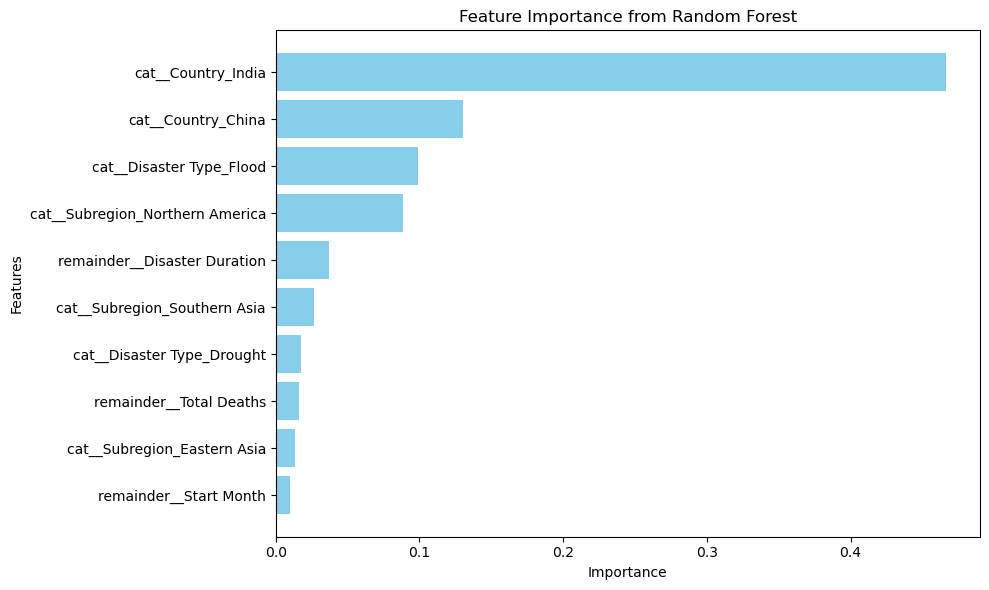

In [47]:
# Extract feature importances from the Random Forest model
importances = xgb_model.feature_importances_


# Get feature names from the one hot encoder
feature_names = onehot.get_feature_names_out()

# print(f"Shape of X: {X_train_encoded.shape}")
# print(f"Length of feature importances: {len(importances)}")
# print(f"Length of feature names: {len(feature_names)}")

# Create a DataFrame to hold feature names and their corresponding importance scores
important_features = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by importance
important_features = important_features.sort_values(by='Importance', ascending=False).head(10)

# Print the top 10 most important features
print("Top 10 Important Features:")
print(important_features.head(10))

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(important_features['Feature'], important_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()